# initialization

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1vkXUOP4lGvCaARhFOirBgj1VwmkX0VI-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('cleaning_1.xlsx') 

In [ ]:
downloaded = drive.CreateFile({'id':'1uWVz1y4tu3UTi7UXAEM1D4cy2KJpdUw8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('stop_words.txt') 

# Preprocessing

# Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
df = pd.read_excel (r'cleaning_1.xlsx')
df.shape

In [ ]:
df['intent'].replace(to_replace=[' drug+dose','drug+dose', 'drug+dpse'], value='drugs', inplace=True)
df['intent'].replace(to_replace=['contageos', 'contagious'] ,value ='contageous', inplace=True)
df['intent'].replace(to_replace=['info', 'Info'], value='information', inplace=True)

In [ ]:
indexNames=df[(df['intent'] =='drugs') 
              | (df['intent'] =='food+product') 
              | (df['intent']=='vaccine')
              |(df['intent'] =='symptoms')].index.tolist()

In [ ]:
df=df.iloc[indexNames,:]

In [ ]:
df.intent.unique() , df.shape

In [ ]:
df[df.intent=='food+product'].values

# clean data

In [ ]:
# ==== Helper Methods =====
import re
import numpy as np
from nltk import ngrams
import matplotlib.pyplot as plt

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [ ]:
df['question'] =  df['question'].apply(lambda x: clean_str(x))

# Stop Words

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

In [ ]:

from nltk.corpus import stopwords
stopwords_list = stopwords.words('arabic')
#print(stopwords_list)
#---------------------------------------------------------------------------
egyp=[]
# Using readlines()

file1 = open("stop_words.txt", "r" ,encoding = "utf-8")
Lines = file1.readlines()
count = 0
# Strips the newline character
for line in Lines:
    count += 1
    egyp.append(line.strip())
    
    #print( line.strip())
#print(egyp)
#----------------------------------------------------------------------------
# combine two lists
egyp=egyp+stopwords_list

In [ ]:
df['question']=df['question'].apply(lambda words: ' '.join(re.sub('^(ال)',"",word)
                                                           for word in words.split() if ((word not in egyp))))


# Over sampling

In [ ]:
dr=df[df["intent"]=='vaccine']


In [ ]:
df_repeated = pd.concat([df[df["intent"]=='vaccine']]*3, ignore_index=True)  # vaccine 59*4=236
frames = [df_repeated, df]
result = pd.concat(frames)

In [ ]:
X = result['question']
y = result['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

# Naive Bayes classifier for multinomial models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


#{'clf__alpha': 0.1,
 #'tfidf__norm': 'l2',
 #'tfidf__use_idf': False,
 #'vect__ngram_range': (1, 1)}


X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

nb = Pipeline([('vect', CountVectorizer(max_features=24 )),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB(alpha=0.1)),
              ])
nb.fit(X_train, y_train);

In [ ]:
%%time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# Linear support vector machine

In [ ]:
from sklearn.linear_model import SGDClassifier


X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)


sgd = Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier( n_jobs=-1,loss='hinge', penalty='l1',alpha=0.01, random_state=42, max_iter=20, tol=None)),
               ])
sgd.fit(X_train, y_train);

In [ ]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# sgd gridsearch

In [ ]:
pip install parfit

In [ ]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import roc_auc_score
# import parfit.parfit as pf

# grid = {
#     'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
#     'n_iter': [1000], # number of epochs
#     'loss': ['log'], # logistic regression,
#     'penalty': ['l2'],
#     'n_jobs': [-1]
# }
# paramGrid = ParameterGrid(grid)

# bestModel, bestScore, allModels, allScores = 
# pf.bestFit(SGDClassifier, paramGrid,
#            X_train, y_train, X_val, y_val, 
#            metric = roc_auc_score, bestScore='max',
#            scoreLabel = "AUC")

# print(bestModel, bestScore)

In [ ]:
from sklearn.model_selection import GridSearchCV
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

In [ ]:



parameters={
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
     #'clf__n_iter': [1000], # number of epochs
     'clf__loss': ['log','hinge'], # logistic regression,
     'clf__penalty': ['l2','l1'],
     'clf__n_jobs': [-1,1]
 }
sgd = Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier( random_state=42, max_iter=5, tol=None)),
               ])
 


In [ ]:
grid_pipeline = GridSearchCV(sgd,parameters , cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

In [ ]:
df2=pd.DataFrame(grid_pipeline.cv_results_)

# Logistic regression

In [ ]:
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
piplrtf = Pipeline([('vect', CountVectorizer(max_features=380)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=0.3,penalty='l1',solver='liblinear',multi_class='ovr')),
                
               ])
               
piplrtf.fit(X_train, y_train);

In [ ]:

%%time

y_pred = piplrtf.predict(X_test)



#print('accuracy %s' % accuracy_score(y_pred, y_test))

print("normal data LR + countervectorizer c=0.3 , penality = l1 solver=liblinear \n")
print(classification_report(y_test, y_pred))



In [ ]:
pickle.dump(piplrtf, open('tfidfبب_reg.pkl', 'wb'))
 
# some time later...
 
# load the model from disk
tfidf_lr = pickle.load(open('tfidfبب_reg.pkl', 'rb'))
q=pd.Series(' ابني اعبان بقاله فتره و عنده كحه و عطس المفروض اديله ايه')
tfidf_lr.predict_proba(q)

#tfidf_lr.predict(q)


array([[0.31503697, 0.0909701 , 0.57542793, 0.018565  ]])

In [ ]:
tfidf_lr.predict(q)

array(['symptoms'], dtype=object)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression()
# define the ovr strategy
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)

# learning curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve


X, y = df['question'], df['intent']

MOD=Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=0.3,solver='liblinear',penalty='l1')),
               ])

train_sizes, train_scores, test_scores = learning_curve(MOD, X, y, cv=10, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------------------------

# Doc2vec and Logistic Regression

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re




/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

#X_train, X_test, y_train, y_test = train_test_split(df.question, df.intent, random_state=0, test_size=0.3, stratify=y)

#X_train, X_test, y_train, y_test = train_test_split(df.question, df.intent, random_state=0, test_size=0.3, stratify=y)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

In [ ]:

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 100, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 100, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1)
logreg.fit(train_vectors_dbow, y_train)

In [ ]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

# saving and calling

In [ ]:
import pickle


pickle.dump(model_dbow, open('doc2vec', 'wb'))
 
# some time later...
 
# load the model from disk
doc2vecmodel = pickle.load(open('doc2vec', 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [ ]:
pickle.dump(logreg, open('LR_doc2vec', 'wb'))
 
# some time later...
 
# load the model from disk
lrmodel = pickle.load(open('LR_doc2vec', 'rb'))

In [ ]:

q=pd.Series('تطعيم')
X_test= label_sentences(q, 'Test')
all_data=X_test

test_vectors_dbow = get_vectors(doc2vecmodel, len(X_test), 100, 'Test')
y_pred = lrmodel.predict(test_vectors_dbow)

y_pred   

array(['symptoms'], dtype=object)

array(['symptoms'], dtype=object)

# regulization

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.learning_curve import validation_curve
from sklearn.model_selection import learning_curve, GridSearchCV


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

#X = df['question']
#y = df['intent']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)



#C_param_range = [0.001,0.01,0.1,1,10,100]

C_param_range = [0.001,0.01,0.1,1,10,100,0.01,0.03,0.3,3,30]


sepal_acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
sepal_acc_table['C_parameter'] = C_param_range

plt.figure(figsize=(10, 10))

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(n_jobs=1, C=i)

    #lr.fit(X_train_sepal_std,y_train_sepal)
    lr.fit(train_vectors_dbow, y_train);
    # Predict using model
    y_pred = lr.predict(test_vectors_dbow)


    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, confusion_matrix
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))






    # Saving accuracy score in table
    sepal_acc_table.iloc[j,1] = accuracy_score(y_pred, y_test)
    j += 1
    
sepal_acc_table

# REGULI

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.learning_curve import validation_curve
from sklearn.model_selection import learning_curve, GridSearchCV


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)



#C_param_range = [0.001,0.01,0.1,1,10,100]

#C_param_range = [0.001,0.01,0.1,1,10,100,0.01,0.03,0.3,3,30]

C_param_range =[0.01,0.03,0.1,0.3,1,3,10,30,100]

sepal_acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
sepal_acc_table['C_parameter'] = C_param_range

plt.figure(figsize=(10, 10))

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = Pipeline([('vect', CountVectorizer(max_features=24)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=i ,penalty='l1',solver='liblinear')),
               ])
    #lr.fit(X_train_sepal_std,y_train_sepal)
    lr.fit(X_train, y_train);
    # Predict using model
    y_pred = lr.predict(X_test)

    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score, confusion_matrix
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))





    # Saving accuracy score in table
    sepal_acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)
    j += 1
    
sepal_acc_table

# pipline grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

In [ ]:
pip= Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1)),
               ])
 
parameters={'vect__max_features':[24],
        'clf__C':[0.01,0.03,0.1,0.3,1,3,10,30,100],
        'tfidf__use_idf': (True, False),
        'clf__penalty':['l1','l2','none'],
        
        'clf__solver':["liblinear",'auto']
        }

In [ ]:
grid_pipeline = GridSearchCV(pip,parameters , cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

In [ ]:
grid_pipeline.cv_results_;

In [ ]:
df2=pd.DataFrame(grid_pipeline.cv_results_)
#df2

In [ ]:
x=df2[[	'param_clf__C','mean_test_score'	]]
x.head(60)

,param_clf__C,mean_test_score
0,0.01,0.429895
1,0.01,0.429895
2,0.03,0.474205
3,0.03,0.476845
4,0.1,0.641564
5,0.1,0.640902
6,0.3,0.646202
7,0.3,0.645542
8,1,0.644874
9,1,0.643549


In [ ]:
#x.tail(70)

In [ ]:
grid_pipeline.best_params_

{'clf__C': 0.3,
 'clf__penalty': 'l1',
 'clf__solver': 'liblinear',
 'tfidf__use_idf': False,
 'vect__max_features': 24}

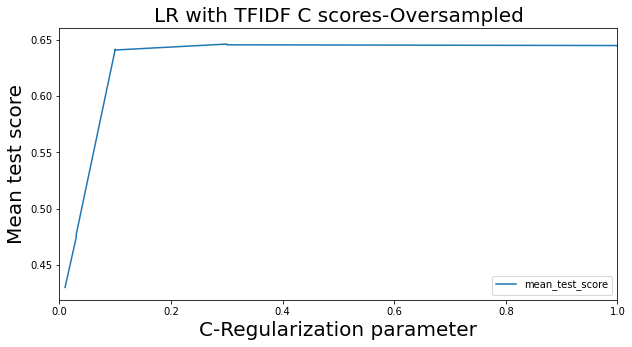

In [ ]:
x['mean_test_score'].values

ax1=x.plot(x='param_clf__C',y='mean_test_score',figsize=((10,5)));
ax1.set_xlim(0,1);

plt.xlabel('C-Regularization parameter',fontsize=20); 
plt.ylabel('Mean test score',fontsize=20); 
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)   
# displaying the title
plt.title("LR with TFIDF C scores-Oversampled",fontsize=20);


# naive baiyes tuning

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV


X = df['question']
y = df['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2,0.3]
}

In [ ]:
grid_pipeline = GridSearchCV(text_clf,parameters , cv=5)
# fit
grid_pipeline.fit(X_train,y_train)
grid_pipeline.best_params_

{'clf__alpha': 0.1,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

In [ ]:
df22=pd.DataFrame(grid_pipeline.cv_results_)
df22

# trials

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re



def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled



#------------------------------------------------------------------------
def get_vectors(model, corpus_size, vectors_size, vectors_type):
  """
  Get vectors from trained doc2vec model
  :param doc2vec_model: Trained Doc2Vec model
  :param corpus_size: Size of the data
  :param vectors_size: Size of the embedding vectors
  :param vectors_type: Training or Testing vectors
  :return: list of vectors
  """
  vectors = np.zeros((corpus_size, vectors_size))
  for i in range(0, corpus_size):
      prefix = vectors_type + '_' + str(i)
      vectors[i] = model.docvecs[prefix]
  return vectors

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
X = df['question']
y = df['intent']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0025, random_state = 42,stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42,stratify=y)

X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

#-----------------------------------------------------------------------------------------------
model_dbow = Doc2Vec(dm=0, vector_size=24, negative=5, min_count=3, alpha=0.065, min_alpha=0.065)



reg=10
ep=20


#model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                 # dm_mean=1, # dm = 1 for using mean of the context word vectors
                                 # size=200, # no. of desired features
                                 # window=5, # width of the context window
                                 # negative=7, # if > 0 then negative sampling will be used
                                  #min_count=5, # Ignores all words with total frequency lower than 2.
                                 # workers=3, # no. of cores
                                 # alpha=0.1, # learning rate
                                 # seed = 23)



# model_dbow = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
#                                   dm_mean=1, # dm = 1 for using mean of the context word vectors
#                                   size=25, # no. of desired features
#                                   window=5, # width of the context window
#                                   negative=7, # if > 0 then negative sampling will be used
#                                   min_count=5, # Ignores all words with total frequency lower than 2.
#                                   workers=3, # no. of cores
#                                   alpha=0.1, # learning rate
#                                   seed = 23)

model_dbow.build_vocab([x for x in tqdm(all_data)])
#--------------------------------------------------------------------------------------
for epoch in range(ep):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha   

#--------------------------------------------------------------------------------------------------- 
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 24, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 24, 'Test')
#---------------------------------------------------------------------------

#-------------------------------------------------
#---------------------------------------------------

# parameters={
#         'clf__C':[0.01,0.03,0.1,0.3,1,3,10,30,100],
      
#         'clf__penalty':['l1','l2','none'],
        
#         'clf__solver':["liblinear",'auto']
#         }

# logreg= Pipeline([
#                 ('clf', LogisticRegression(n_jobs=1)),
#                ])       


# grid_pipeline = GridSearchCV(logreg,parameters , cv=5)
# # fit
# grid_pipeline.fit(train_vectors_dbow, y_train)
# grid_pipeline.best_params_
#------------------------------------------------------------------------
logreg = LogisticRegression(n_jobs=1, C=reg , solver='liblinear',penalty='l1')
logreg.fit(train_vectors_dbow, y_train)
#-----------------------------------------------------------------------------

logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
#-----------------------------------------------------

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy %s' % accuracy_score(y_pred, y_test))


print(" doc2vec"+" [ C="+str(reg)+" epoch="+str(ep)+" ]")
print(classification_report(y_test, y_pred))



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import learning_curve








#X, y = df['question'], df['intent']

MOD=Pipeline([
                ('clf', LogisticRegression(n_jobs=1,C=reg,solver='liblinear',penalty='l1')),
             ]) 

train_sizes, train_scores, test_scores = learning_curve(MOD, train_vectors_dbow, y_train, cv=10, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(0.01, 1.0, 50),)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve [ C="+str(reg)+" epoch="+str(ep)+" ]")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()
